In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
from decimal import Decimal
from tqdm import tqdm
from lmfit import minimize, Parameters, report_fit

#calibration curves parameters
slope = 15.36915365;
intercept = 0;    

#annotate experimental parameters so that experiments can be analyzed in aggregate later
def annotateExp(df):
    result = df.copy();
    
    result['Date'] = 201021;
    result['Setup_Number'] = 2;
    result['Device_Type'] = '2-block'
    result['Device_Num'] = 1;

    result['Print_date'] = 201005;
    result['Print_slide'] = 2;
    result['Print_Pin_Type'] = 'PDC70';
    
    result['data_directory'] = '/Users/connor/Documents/fordycelab/'
    
    return result;


# objective function calculates residuals of fits
def objective(params, oligo_list, ratio, chamber):
    resid = np.zeros(ratio.shape)
    # make residual per data set
    for i in oligo_list:
        resid[i-1, :] = ratio[i-1, :] - isotherm_dataset(params, i, chamber[i-1,:])
    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

# function to calculate for fit
def isotherm(x,ymax,Kd):
    y = [ymax*DNA/(DNA+Kd) for DNA in x]
    return y

def isotherm_dataset(params, i, x):
    """calc isotherm from params for data set i
    using simple, hardwired naming convention"""
    Kd = params['Kd_%i' % i].value
    ymax = params['ymax'].value
    return isotherm(x, ymax, Kd)

In [3]:
# import prewash Cy5 data
prewash_Cy5 = pd.read_csv('/Volumes/Elements/201021_Pho4_repeatlibrary1_lowTF/d1/affinity/prewash_cy5/201021_Pho4_d1_lowconc_repeatlibrary1_prewashcy5.csv')

prewash_Cy5 = prewash_Cy5.add_suffix('_PrewashCy5')
prewash_Cy5.rename(columns={'x_PrewashCy5': 'x','y_PrewashCy5': 'y','id_PrewashCy5': 'id'}, inplace=True)
prewash_Cy5['Chamber_Index'] = prewash_Cy5['x'].map(str)+','+prewash_Cy5['y'].map(str)

# import postwash GFP data 
postwash_GFP = pd.read_csv('/Volumes/Elements/201021_Pho4_repeatlibrary1_lowTF/d1/affinity/postwash_gfp/201021_Pho4_d1_lowconc_repeatlibrary1_postwashgfp.csv')
postwash_GFP = postwash_GFP.add_suffix('_PostwashGFP')
postwash_GFP.rename(columns={'x_PostwashGFP': 'x','y_PostwashGFP': 'y','id_PostwashGFP': 'id'}, inplace=True)
postwash_GFP['Chamber_Index'] = postwash_GFP['x'].map(str)+','+postwash_GFP['y'].map(str)


# import postwash Cy5 data 
postwash_Cy5 = pd.read_csv('/Volumes/Elements/201021_Pho4_repeatlibrary1_lowTF/d1/affinity/postwash_cy5/201021_Pho4_d1_lowconc_repeatlibrary1_postwashcy5.csv')
postwash_Cy5 = postwash_Cy5.add_suffix('_postwashCy5')
postwash_Cy5.rename(columns={'step_postwashCy5':'step','x_postwashCy5': 'x','y_postwashCy5': 'y','id_postwashCy5': 'id'}, inplace=True)
postwash_Cy5['Chamber_Index'] = postwash_Cy5['x'].map(str)+','+postwash_Cy5['y'].map(str)


#now perform merging: common columns are x, y, id, and step
postwash_df = pd.merge(postwash_GFP,postwash_Cy5, how='left',on=['id','x','y','Chamber_Index'])
rawdata_df = pd.merge(postwash_df, prewash_Cy5, how='left', on=['id','x','y','Chamber_Index'])

#drop all columns with '0_0' id (blank chambers)
rawdata_df = rawdata_df[rawdata_df['id']!='0_0']

In [4]:
#calculate ratio
rawdata_df['R_bSub'] = rawdata_df['summed_button_BGsub_postwashCy5']/rawdata_df['summed_button_BGsub_PostwashGFP']

In [5]:
#split the id into two columns one is the oligo identity and the other is the oligo concentration...
rawdata_df['Oligo_Identity'] = rawdata_df['id'].apply(lambda x: int(x.split('_')[0]))
rawdata_df['Oligo_Concentration'] = rawdata_df['id'].apply(lambda x: int(x.split('_')[1]))

#map intensity to DNA concentration
exposure = 200
rawdata_df['DNA_Conc_Std'] = (rawdata_df['median_chamber_PrewashCy5']*300)/(slope*exposure)

/Users/connor/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


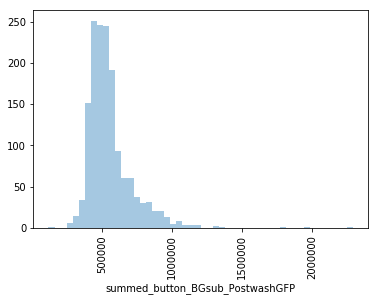

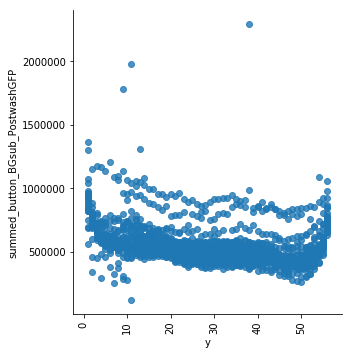

In [6]:
# visualize the protein distribution overall in the device to assist with culling on the dataset

g = sns.distplot(rawdata_df['summed_button_BGsub_PostwashGFP'],kde=False)
plt.xticks(rotation=90)
plt.show()

g = sns.lmplot(x='x',y='summed_button_BGsub_PostwashGFP',data=rawdata_df,fit_reg=False)
plt.xticks(rotation=90)
plt.show()

g = sns.lmplot(x='y',y='summed_button_BGsub_PostwashGFP',data=rawdata_df,fit_reg=False)
plt.xticks(rotation=90)
plt.show()



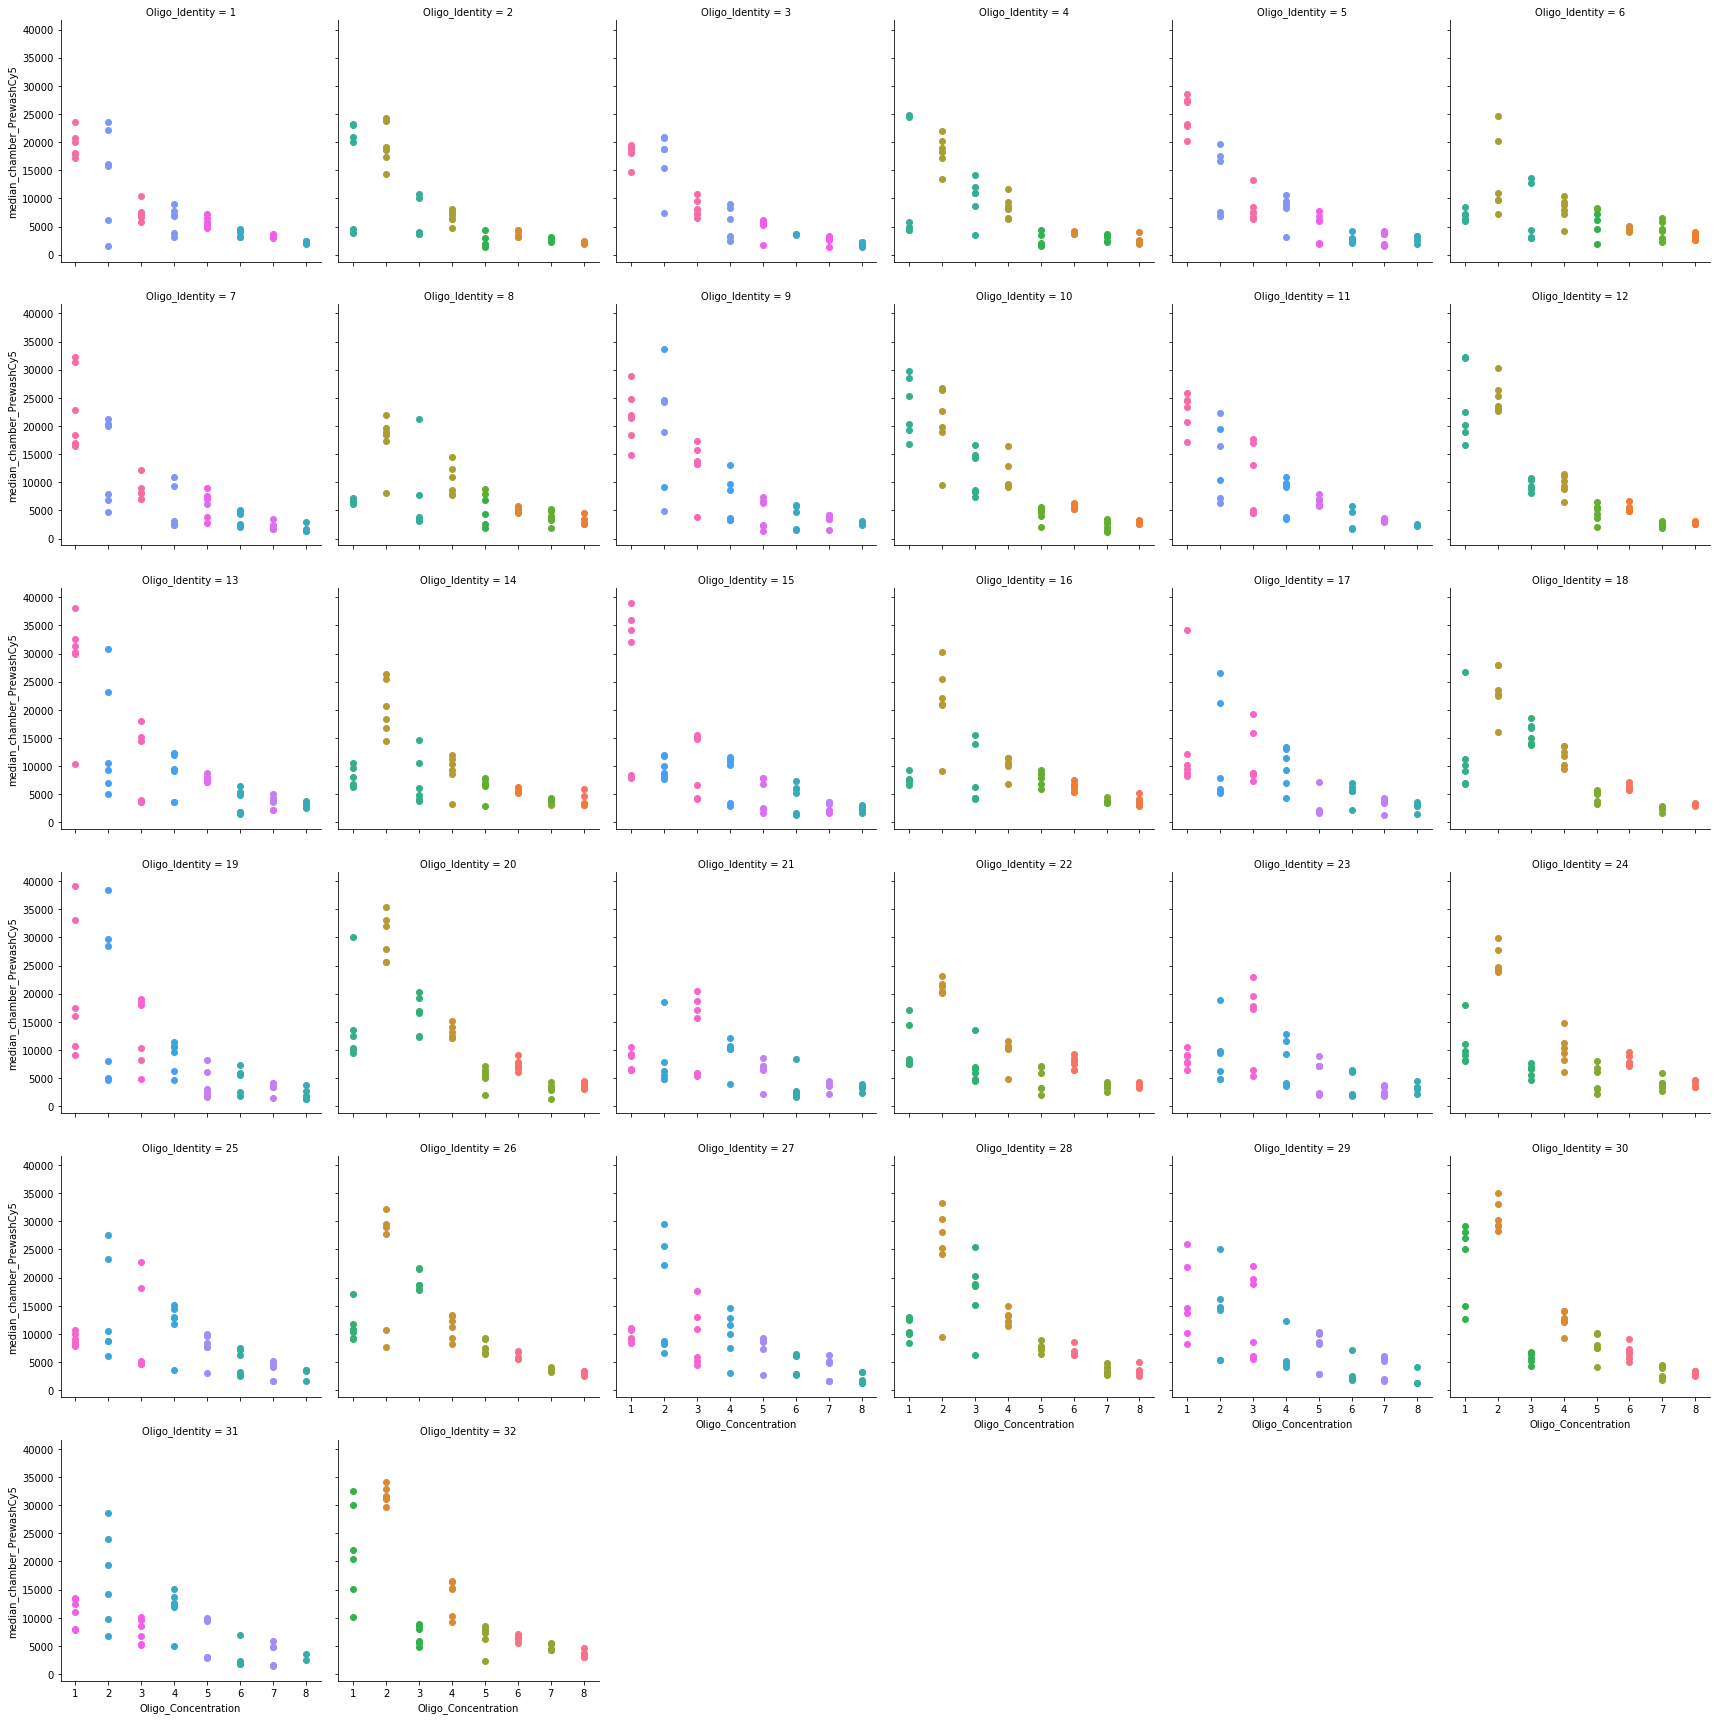

In [9]:
# visualize DNA fluorescence across oligos

g = sb.FacetGrid(rawdata_df, col = "Oligo_Identity",col_wrap=6, height = 4, hue='x')
g = g.map(pl.scatter,"Oligo_Concentration", "median_chamber_PrewashCy5")
pl.show()


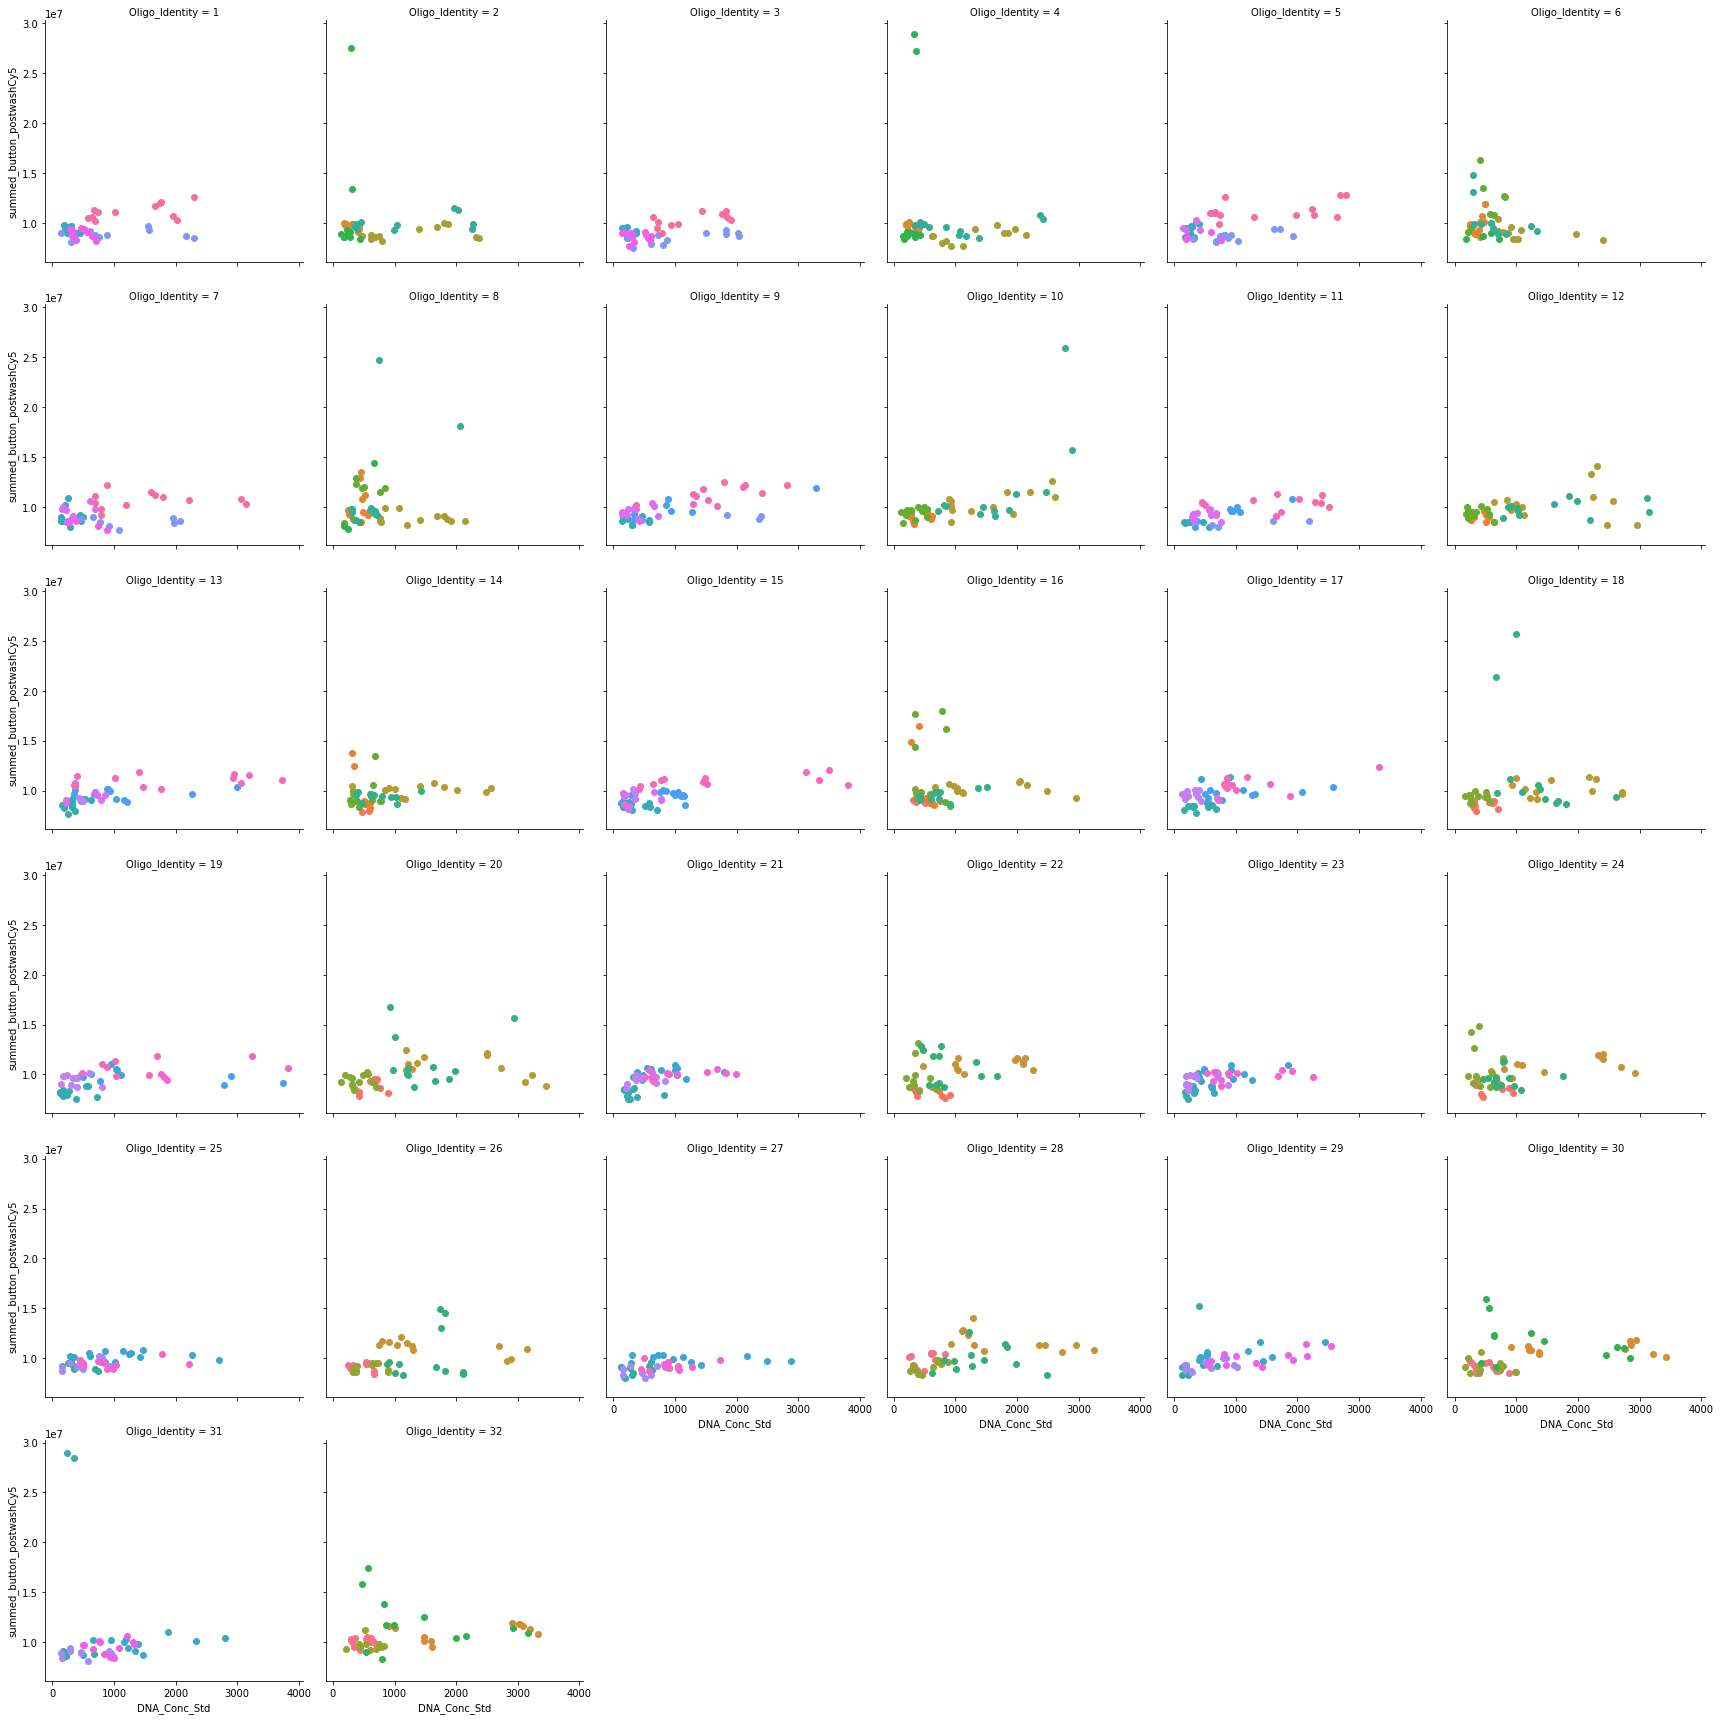

In [7]:
g = sns.FacetGrid(rawdata_df, col = "Oligo_Identity",col_wrap=6, height = 4, hue='x')
g = g.map(plt.scatter,"DNA_Conc_Std", "summed_button_postwashCy5")
plt.show()

In [16]:
# Excluding first and last column and first 10 rows
bad_columns = [1,2,27,28]
bad_rows = [1,2,55,56]

filtered_data = rawdata_df[~rawdata_df['x'].isin(bad_columns)]
filtered_data = filtered_data[~filtered_data['y'].isin(bad_rows)]

filtered_data = filtered_data[filtered_data['summed_button_BGsub_PostwashGFP'] < 8.2e5]
filtered_data = filtered_data[filtered_data['summed_button_BGsub_PostwashGFP'] > 3e5]

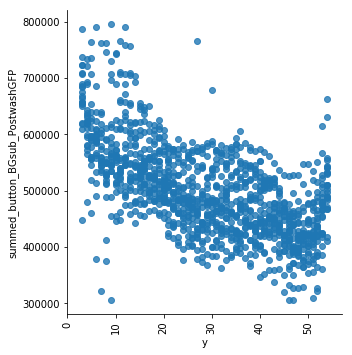

In [17]:
# visualize protein distribution again to assess data culling

g = sns.lmplot(x='x',y='summed_button_BGsub_PostwashGFP',data=filtered_data,fit_reg=False)
plt.xticks(rotation=90)
plt.show()

g = sns.lmplot(x='y',y='summed_button_BGsub_PostwashGFP',data=filtered_data,fit_reg=False)
plt.xticks(rotation=90)
plt.show()

In [18]:
filtered_data = filtered_data[filtered_data['R_bSub'] > 0]
filtered_data = filtered_data[filtered_data['R_bSub'] < 5]

g = sns.FacetGrid(filtered_data, col = "Oligo_Identity",col_wrap=6, height = 4, hue='summed_button_BGsub_PostwashGFP', palette='magma')
g = g.map(plt.scatter,"DNA_Conc_Std", "R_bSub")
plt.show()

In [66]:
# create new dataframe with only the data necessary to fit curves
GFIT_Input = pd.DataFrame();

GFIT_Input['Onum'] = rawdata_df_columnFilter['Oligo_Identity'].astype('int')
GFIT_Input['R'] = rawdata_df_columnFilter['R_bSub']
GFIT_Input['Ch'] = rawdata_df_columnFilter['DNA_Conc_Std']
GFIT_Input = GFIT_Input.dropna().reset_index(drop=True)

# export for safekeeping
GFIT_Input.to_csv('/Volumes/Elements/201021_Pho4_repeatlibrary1_lowTF/d1/affinity/201021_d1_Pho4_lowTF_lib1_GFIT_Input.csv', sep=',', index = False)


In [68]:
# SET UP FIT PARAMETERS

fit_params = Parameters()

for i in rawdata_df_columnFilter['Oligo_Identity'].unique():
    fit_params.add( 'Kd_%s' % i, value=1e3, min=1e1,  max=1e6)

Rmax_guess = np.max(GFIT_Input['R'])
fit_params.add('ymax', value=Rmax_guess, min=0.01,  max=10)

In [69]:
oligo_list = list(set(rawdata_df_columnFilter['Oligo_Identity']))
oligo_list = [int(i) for i in oligo_list]
num_oligos = len(oligo_list)

In [70]:
Kd_fits = np.zeros((n_iters, len(oligo_list)))
rmax_fits = np.zeros(n_iters)

In [71]:
for i in tqdm(range(n_iters)):
    rand = np.random.choice(n_total, n_sample, replace=False)
    subset_df = GFIT_Input.loc[rand]
    
    
    max_len = np.max(subset_df['Onum'].value_counts())
    data_ratios = np.zeros((32, max_len))
    data_chambers = np.zeros((32, max_len))
    
    for j in oligo_list:
        ratios = list(subset_df[subset_df['Onum']==j]['R'])
        data_ratios[int(j)-1,:len(ratios)] = ratios
        chambers = list(subset_df[subset_df['Onum']==j]['Ch'])
        data_chambers[int(j)-1,:len(chambers)] = chambers

    
    result_global = minimize(objective, fit_params, args=(oligo_list, data_ratios, data_chambers))  

    Kd_fits[i,:] = [result_global.params['Kd_%s' % k].value for k in oligo_list]
    rmax_fits[i] = result_global.params['ymax'].value

100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


In [72]:
# store values

Kd_means = np.mean(Kd_fits, axis=0)
Kd_sdevs = np.std(Kd_fits, axis=0)

rmax = np.mean(rmax_fits)

summary_stats_df = pd.DataFrame(np.vstack([oligo_list, Kd_means, Kd_sdevs]).T, columns=['Oligo_Identity','Kd_mean','Kd_sdev'])
summary_stats_df['Oligo_Identity'] = summary_stats_df['Oligo_Identity'].astype('str').apply(lambda x: x[:-2]).astype('int')

In [73]:
summary_stats_df.to_csv('/Volumes/Elements/201021_Pho4_repeatlibrary1_lowTF/d1/affinity/201021_d1_Pho4_lowTF_lib1_GFIT_Output.csv', sep=',', index = False)

In [75]:
# get oligonames and left join
oligonames = pd.read_csv('/Users/connor/Documents/fordycelab/plates_oligos_plasmids/181114_oligonames.csv', dtype={'Oligo_Identity': int,'Title': str})
# rawdata_df = rawdata_df.merge(oligonames, on='Oligo_Identity', how='left')

num_oligos = oligonames['Oligo_Identity'].astype('int64').max() # should be 48 for this dataset

In [76]:
annotated_df = rawdata_df_columnFilter.merge(summary_stats_df, on='Oligo_Identity')

In [77]:
annotated_df = annotated_df.merge(oligonames, on='Oligo_Identity')

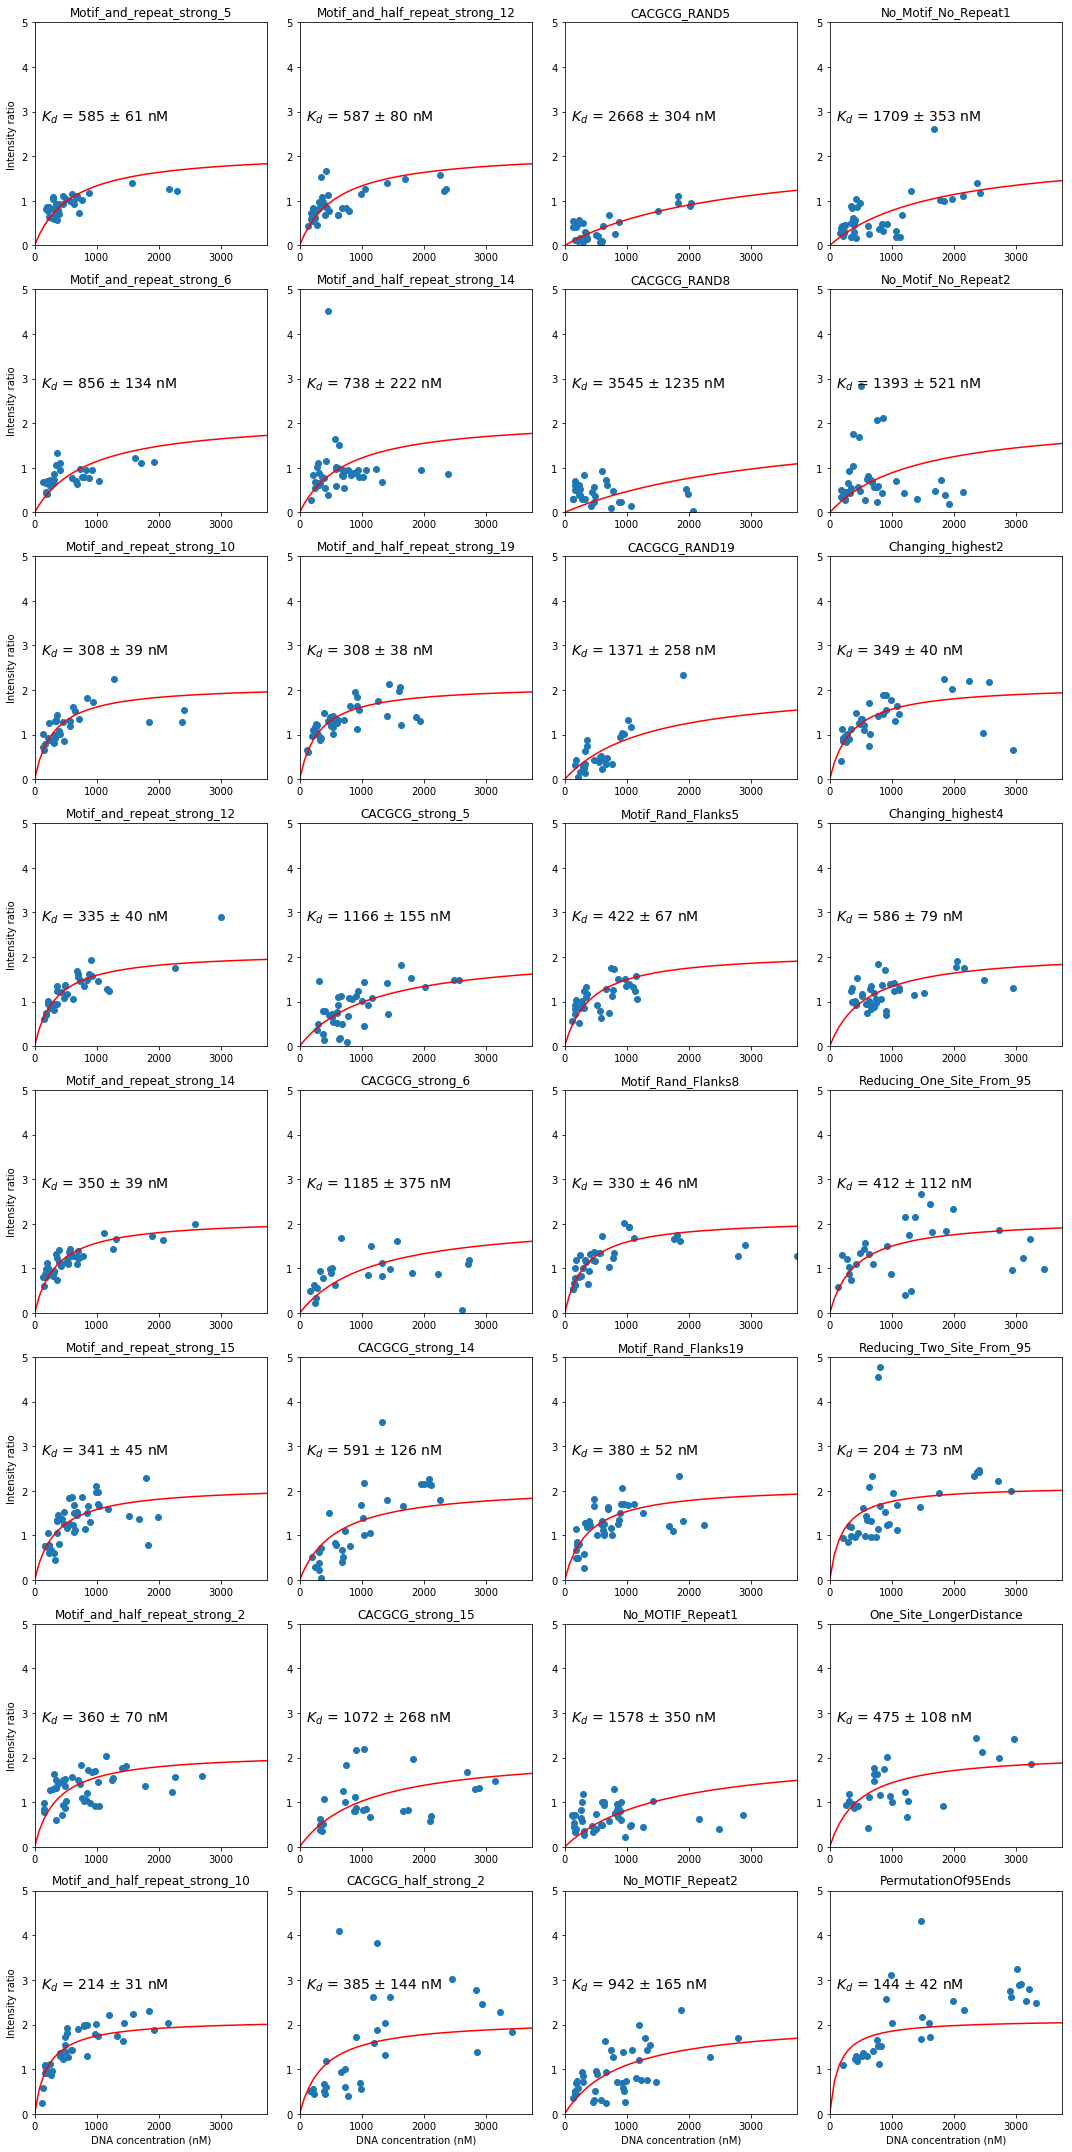

In [78]:
fig = pl.figure(figsize=(15,30))
nrow = 8
ncol = 4
for i in range(num_oligos):
    ax = fig.add_subplot(nrow,ncol,i+1)
    df_to_plot = annotated_df[annotated_df['Oligo_Identity'] == (i+1)]
    ax.scatter(df_to_plot['DNA_Conc_Std'], df_to_plot['R_bSub']);
    x = np.linspace(0,annotated_df['DNA_Conc_Std'].max())
#     koff = df_to_plot['koff_fitted'].tolist()[0]*10**(-9)
#     kon = df_to_plot['kon_calc'].tolist()[0]
    ax.set_xlim((0,annotated_df['DNA_Conc_Std'].max()))
    ax.set_ylim((0,5))
    if i % ncol == 0:
        ax.set_ylabel('Intensity ratio')
    if num_oligos - i - 1 < ncol: 
        ax.set_xlabel('DNA concentration (nM)')
    if len(df_to_plot['Kd_mean']) > 0:
        ax.plot(x,isotherm_single(x,list(df_to_plot['Kd_mean'])[0],rmax),color='red')
        ax.text(100, 2.8, "$K_d$ = %.f $\pm$ %.f nM" % (list(df_to_plot['Kd_mean'])[0], list(df_to_plot['Kd_sdev'])[0]), fontsize=14)
        ax.set_title(list(df_to_plot['Title'])[0])
   
fig.tight_layout()
# pl.show()

# fig.savefig('/Volumes/Elements/201023_egfp_control_library1/d1/affinity/201023_egfp_control_repeatlib1_affinitycurves.png')